<a href="https://colab.research.google.com/github/AhmedEhab2022/movie_recommendation_system/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [ ]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Google Colab integration
from google.colab import drive

# Import the dataset

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path1 = "/content/drive/MyDrive/Movie Recommendation System/ml-100k/u.data"

ratings = pd.read_csv(path1, sep="\t", names=["userId", "movieId", "rating", "timestamp"])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
path2 = "/content/drive/MyDrive/Movie Recommendation System/ml-100k/u.item"

cols = [
    "movieId",
    "title",
    "release_date",
    "video_release_date",
    "IMDb_URL",
] + [f"genre_{i}" for i in range(19)]

movies = pd.read_csv(path2, sep="|", encoding="latin-1", names=cols)
movies.head()

,movieId,title,release_date,video_release_date,IMDb_URL,genre_0,genre_1,genre_2,genre_3,genre_4,...,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Get relevant columns

In [ ]:
df = pd.merge(ratings, movies[["movieId", "title"]], on="movieId")
df = df[["userId", "title", "rating"]]
df = df.rename(columns={"title": "movie_title"})
df.head()

,userId,movie_title,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


# Exploration Data Analysis (EDA)

## Basic info

In [ ]:
df.shape

(100000, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   userId       100000 non-null  int64 
 1   movie_title  100000 non-null  object
 2   rating       100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [ ]:
df.describe()

,userId,rating
count,100000.00000,100000.000000
mean,462.48475,3.529860
std,266.61442,1.125674
min,1.00000,1.000000
25%,254.00000,3.000000
50%,447.00000,4.000000
75%,682.00000,4.000000
max,943.00000,5.000000


## Ratings distribution

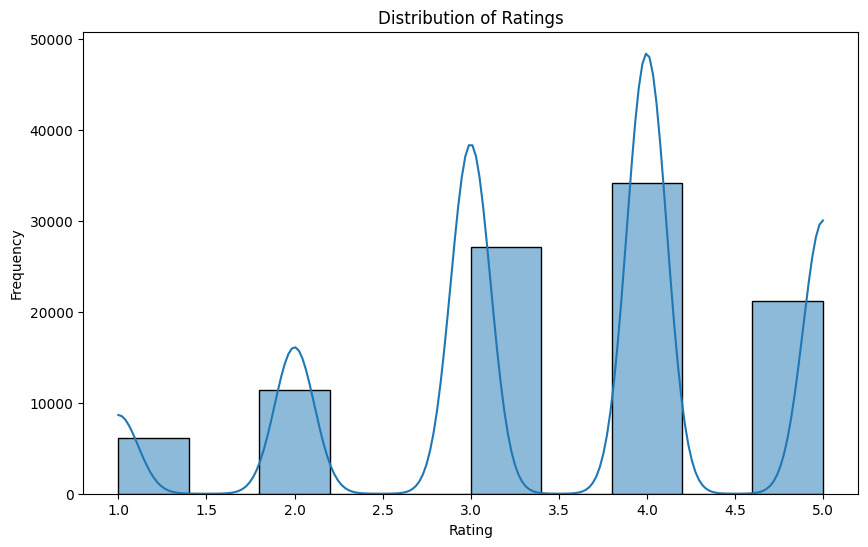

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df["rating"], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Cleaning the dataset

In [ ]:
df.isnull().sum()

,0
userId,0
movie_title,0
rating,0


In [ ]:
df.duplicated().sum()

np.int64(261)

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
df[["userId", "movie_title"]].duplicated().sum()

np.int64(46)

In [ ]:
df.drop_duplicates(["userId", "movie_title"], inplace=True)
df[["userId", "movie_title"]].duplicated().sum()

np.int64(0)

In [ ]:
df["userId"] = df["userId"] - 1
df.head()

,userId,movie_title,rating
0,195,Kolya (1996),3
1,185,L.A. Confidential (1997),3
2,21,Heavyweights (1994),1
3,243,Legends of the Fall (1994),2
4,165,Jackie Brown (1997),1


# Splitting the dataset

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Build user-item matrix

A user-item matrix is a table in recommendation systems, where rows represent users and columns represent items (such as movies), with entries indicating a user's interaction or preference (e.g., a rating or click) for a specific item.

By understanding these relationships, the system can predict what items a user might like but hasn't interacted with yet, and suggest them as recommendations.

In [ ]:
user_item_matrix = X_train.pivot_table(index="userId", columns="movie_title", values="rating")
user_item_matrix.head()

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,2.0,5.0,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


# Calculate user and item similarity

A similarity matrix is a quantitative tool used to measure the pairwise similarity between items, with higher values indicating greater similarity and lower values indicating dissimilarity. It is a square matrix where each element represents the similarity score between two objects or variables.

In [ ]:
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_similarity

array([[1.        , 0.15264427, 0.029791  , ..., 0.08431897, 0.13552779,
        0.32400489],
       [0.15264427, 1.        , 0.09837036, ..., 0.14318004, 0.11776709,
        0.07070915],
       [0.029791  , 0.09837036, 1.        , ..., 0.10767638, 0.03815491,
        0.01841227],
       ...,
       [0.08431897, 0.14318004, 0.10767638, ..., 1.        , 0.        ,
        0.0854982 ],
       [0.13552779, 0.11776709, 0.03815491, ..., 0.        , 1.        ,
        0.11052023],
       [0.32400489, 0.07070915, 0.01841227, ..., 0.0854982 , 0.11052023,
        1.        ]])

In [ ]:
item_similarity = cosine_similarity(user_item_matrix.T.fillna(0))
item_similarity

array([[1.        , 0.        , 0.01381814, ..., 0.        , 0.15666989,
        0.        ],
       [0.        , 1.        , 0.01562776, ..., 0.07963978, 0.05906244,
        0.        ],
       [0.01381814, 0.01562776, 1.        , ..., 0.17839138, 0.03527962,
        0.        ],
       ...,
       [0.        , 0.07963978, 0.17839138, ..., 1.        , 0.        ,
        0.        ],
       [0.15666989, 0.05906244, 0.03527962, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

# Introduction to the recommendation techniques used

## Collaborative Filtering

Collaborative filtering is a recommendation system technique that suggests items to users based on the past behavior and preferences of other users with similar tastes.

Types:
1. User-based collaborative filtering (UBCF) is a recommendation system technique that predicts a user's preferences by identifying other users with similar tastes and leveraging their preferences. The core idea is that if two users have agreed on their preferences for certain items in the past, they are likely to agree on other items in the future.

2. Item-based collaborative filtering (IBCF) is a recommender system technique that predicts user preferences by calculating the similarity between items based on user ratings or interactions, rather than similarities between users

How It Works:
1. Collect User Data:
The system gathers data on how users interact with items, such as movie ratings, product purchases, or song likes.

2. Find Similar Users:
It then identifies users who have similar interaction histories to the target user. For example, if two users have both given high ratings to the same set of movies, they are considered similar.

3. Generate Recommendations:
Based on the identified similar users, the system recommends new items that the target user hasn't interacted with yet, but which the similar users have enjoyed.

## Matrix Factorization

Matrix factorization is a machine learning technique that breaks down a large matrix into the product of smaller, lower-rank matrices, uncovering underlying patterns and structures. It is widely used in recommender systems to predict user preferences for items by decomposing a user-item interaction matrix. Common factorization methods include Singular Value Decomposition (SVD), LU decomposition, and Non-Negative Matrix Factorization (NMF), which find applications in areas like data compression, noise reduction, and feature extraction.

How it works in Recommender Systems:
1. Decomposition:
A user-item interaction matrix (e.g., a rating matrix) is factorized into two smaller matrices: one for users and one for items.

2. Latent Features:
Each row in the user matrix and each column in the item matrix represent latent features that capture hidden characteristics or preferences.

3. Prediction:
By multiplying these lower-rank matrices, the system can reconstruct a prediction of the original rating, estimating how a user might rate an item they haven't seen before.


### Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a fundamental matrix factorization technique that breaks down any rectangular matrix into three other matrices: a product of an orthogonal matrix (U), a diagonal matrix of singular values (Σ), and the transpose of another orthogonal matrix (V^T), represented as A = UΣV^T. SVD is used in diverse applications including dimensionality reduction, data compression, and image processing, by revealing the most important patterns and correlations within a dataset.

It's a powerful tool for dimensionality reduction, transforming features into orthogonal components that can improve model performance in tasks like supervised learning.

# Build latent matrix and calculate approximate ratings

In [ ]:
svd = TruncatedSVD(n_components=10, random_state=42)
latent_matrix = svd.fit_transform(user_item_matrix.fillna(0))
latent_matrix

array([[ 35.17772352,  -1.63372639,  -3.24822818, ...,   0.96812757,
          5.84514344,  -3.11607567],
       [  8.2459508 ,  10.8804732 ,  10.796947  , ...,   1.11511448,
          4.09550402,  -1.60743323],
       [  3.07184586,   5.24706126,   4.1765524 , ...,   0.41937511,
         -2.11266431,  -0.49925256],
       ...,
       [  3.39487879,   4.58737253,   0.32512763, ...,  -0.90642222,
         -1.24721   ,   0.2276238 ],
       [ 10.40338995,  -3.8430447 ,   3.05834596, ...,  -0.18049265,
         -2.92477898,  -3.44061105],
       [ 22.22645512,   2.02243515, -10.07722326, ...,   4.50500573,
         -0.22878738,  -0.16553069]])

In [ ]:
approx_ratings = latent_matrix.dot(svd.components_)
approx_ratings = pd.DataFrame(approx_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)
approx_ratings

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
userId,,,,,,,,,,,,,,,,,,,,,
0,-0.006365,0.051413,0.038248,0.843590,-0.102000,0.953280,0.330965,2.710166,0.006744,0.341683,...,0.000060,0.022099,0.023711,2.900539,1.803762,0.566459,0.526621,-0.014706,0.180276,0.011738
1,0.074627,-0.016731,0.189436,0.086313,0.190371,0.430343,-0.355636,0.078847,0.022075,0.014208,...,-0.007208,0.044484,-0.000317,-0.146202,-0.179645,-0.136098,0.065884,0.037654,0.021177,0.021705
2,0.048348,0.006102,-0.098287,0.065500,0.273907,0.088088,-0.092191,-0.067454,0.009185,-0.062453,...,0.001801,0.042989,-0.001897,-0.002582,0.011399,0.017024,0.107947,-0.013545,0.021082,0.006823
3,0.028333,0.000235,-0.041146,0.071077,0.139444,0.012139,-0.028571,-0.001982,0.004438,-0.024081,...,0.001149,0.022671,-0.000753,0.018149,-0.002570,0.005849,0.026689,-0.006898,0.008322,0.002393
4,-0.082730,0.025443,0.519507,0.055501,-0.125138,-0.065391,0.784448,1.681119,-0.006091,0.520011,...,-0.002752,0.017686,0.005977,2.176417,0.900748,0.358500,0.339538,0.027357,0.092972,-0.043345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.033559,-0.008892,0.664347,0.046576,0.010759,0.562136,-0.089356,-0.155842,0.003663,0.058909,...,-0.007392,-0.011740,0.000079,-0.183259,-0.118730,-0.069150,-0.020171,0.069416,-0.021542,0.008815
939,0.044142,-0.002299,-0.156505,0.767354,0.111363,0.024213,0.036203,1.379608,0.009706,0.186339,...,0.000214,0.044301,0.005449,1.046812,0.273497,0.054643,0.010316,-0.017445,0.049471,-0.001165
940,-0.014252,0.006718,0.219392,-0.037724,0.039869,0.155368,-0.064425,0.097379,-0.000851,-0.015677,...,-0.004132,-0.003919,-0.003658,0.092755,-0.070285,-0.006674,0.092395,0.020850,0.006173,-0.012264


# Generating recommendations

## Utilities

In [ ]:
movie_index_map = {mid: idx for idx, mid in enumerate(user_item_matrix.columns)}

In [ ]:
def pridect_ratings(user_id, unseen_movies, top_sim=5, mode=0):
  if mode == 0:
      return user_based_cf(user_id, unseen_movies, top_sim)
  elif mode == 1:
      return item_based_cf(user_id, unseen_movies, top_sim)
  else:
      return svd_ratings(user_id, unseen_movies)


# user-based collaborative filtering
def user_based_cf(user_id, unseen_movies, top_sim=5):
    ratings = []
    sim_users_index = np.argsort(user_similarity[user_id])[::-1][1:top_sim+1]
    sim_users = user_item_matrix.index[sim_users_index]
    for movie in unseen_movies:
        num = den = 0
        for sim_user in sim_users:
            similarity_score = user_similarity[user_id, sim_user]
            rating = user_item_matrix.loc[sim_user, movie]
            if pd.notna(rating):
                num += similarity_score * rating
                den += abs(similarity_score)
        rate = num / den if den != 0 else 0
        ratings.append((movie, rate))
    return ratings


# item(movie)-based collaborative filtering
def item_based_cf(user_id, unseen_movies, top_sim=5):
    ratings = []
    for movie in unseen_movies:
        num = den = 0
        movie_index = movie_index_map[movie]
        sim_movies_index = np.argsort(item_similarity[movie_index])[::-1][1:top_sim+1]
        sim_movies = user_item_matrix.columns[sim_movies_index]
        for sim_movie in sim_movies:
            sim_movie_index = movie_index_map[sim_movie]
            similarity_score = item_similarity[movie_index, sim_movie_index]
            rating = user_item_matrix.loc[user_id, sim_movie]
            if pd.notna(rating):
                num += similarity_score * rating
                den += abs(similarity_score)
        rate = num / den if den != 0 else 0
        ratings.append((movie, rate))
    return ratings

# SVD
def svd_ratings(user_id, unseen_movies):
    predicted_ratings = approx_ratings.loc[user_id]
    ratings = []
    for movie in unseen_movies:
        if movie in predicted_ratings.index:
            rate = predicted_ratings[movie]
            ratings.append((movie, rate))
    return ratings

In [ ]:
def recommend_top_rated_unseen_movies(user_id, top_n=5, top_sim=5, mode=0):
    if user_id not in user_item_matrix.index:
        return pd.DataFrame(columns=["movie_title", "predicted_rating"])

    unseen_movies = user_item_matrix.columns[user_item_matrix.loc[user_id].isna()]
    if len(unseen_movies) == 0:
        return pd.DataFrame(columns=["movie_title", "predicted_rating"])

    ratings = pridect_ratings(user_id, unseen_movies, top_sim, mode)
    top_rated_unseen_movies = sorted(ratings, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(top_rated_unseen_movies, columns=["movie_title", "predicted_rating"])

## Recommendations

### User-based collaborative filtering

In [ ]:
recommend_top_rated_unseen_movies(1)

,movie_title,predicted_rating
0,Amistad (1997),5.0
1,"Boot, Das (1981)",5.0
2,Dangerous Beauty (1998),5.0
3,Lone Star (1996),5.0
4,Ponette (1996),5.0


### Item(Movie)-based collaborative filtering

In [ ]:
recommend_top_rated_unseen_movies(1, mode=1)

,movie_title,predicted_rating
0,Lone Star (1996),5.0
1,Mighty Aphrodite (1995),5.0
2,"Boot, Das (1981)",5.0
3,Georgia (1995),5.0
4,"Godfather: Part II, The (1974)",5.0


### Singular Value Decomposition (SVD)

In [ ]:
recommend_top_rated_unseen_movies(1, mode=2)

,movie_title,predicted_rating
0,Conspiracy Theory (1997),2.127059
1,"Saint, The (1997)",1.922237
2,Big Night (1996),1.870963
3,Lone Star (1996),1.847562
4,Chasing Amy (1997),1.839504


# Evaluating the recommendation system

## Precision@K (P@K) evaluation technique

Precision@K (P@K) measures the proportion of relevant items within the top K recommendations provided by a system, indicating how effective the system is at placing correct results early in the list.

How to Calculate Precision@K
1. Identify the top K items:
Determine the value of K, which is the number of items you are considering.
2. Count relevant items:
From those K items, count how many are actually relevant to the user's query or interest.
3. Divide by K:
Divide the count of relevant items by the total number of items (K) to get the Precision@K score.

In [ ]:
def get_relevant_movies(user_id, threshold=4):
    user_movies = X_test[X_test["userId"] == user_id]
    return user_movies[user_movies["rating"] >= threshold]["movie_title"].tolist()


def user_precision_at_k(recommended_movies, relevant_movies, k):
    if k == 0 or len(recommended_movies) == 0:
        return 0
    return len(set(recommended_movies[:k]) & set(relevant_movies)) / k


def precision_at_k(users, k=5, top_sim=5, mode=0):
    sum = 0
    valid_users = 0
    for user in users:
        relevant_movies = get_relevant_movies(user)
        recommended_movies = recommend_top_rated_unseen_movies(user, k, top_sim, mode)["movie_title"].tolist()
        if len(relevant_movies) > 0 and len(recommended_movies) > 0:
            valid_users += 1
            sum += user_precision_at_k(recommended_movies, relevant_movies, k)
    return sum / valid_users if valid_users > 0 else 0

In [ ]:
unique_users = X_test["userId"].unique()

## User-based collaborative filtering

In [ ]:
precision_at_k(unique_users)

0.055000000000000125

## Item(Movie)-based collaborative filtering

In [ ]:
precision_at_k(unique_users, mode=1)

0.051956521739130554

## Singular Value Decomposition (SVD)

In [ ]:
precision_at_k(unique_users, mode=2)

0.3295652173913016

# Hyperparameter tuning for SVD

In [ ]:
best_n_components = None
best_precision = 0.0
for n_components in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    latent_matrix = svd.fit_transform(user_item_matrix.fillna(0))
    approx_ratings = latent_matrix.dot(svd.components_)
    approx_ratings = pd.DataFrame(approx_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)
    precision = precision_at_k(unique_users, mode=2)
    if precision > best_precision:
        best_precision = precision
        best_n_components = n_components

print(f"Best number of components: {best_n_components}")
print(f"Best precision: {best_precision}")

Best number of components: 10
Best precision: 0.3295652173913016
